In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator
import numpy as np
import datetime
import os
from omegaconf import OmegaConf, DictConfig, ListConfig

import geopandas as gpd
from shapely.geometry import Point

from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

from sklearn.metrics.pairwise import haversine_distances

from geopy.distance import great_circle

from shapely.geometry import MultiPoint

from tqdm import tqdm


from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="..\\scripts\\config\\"):
    cfg = compose(config_name='config.yaml')

HW CLASSIFICATION

In [5]:
launch_time = "2023-05-13_15-49-08"
cluster_data = pd.read_csv(f"H:\\jupyter\\CityTraffic\\data\\{launch_time}\\clusters_{launch_time}.csv")
df = pd.read_csv(f"H:\\jupyter\\CityTraffic\\data\\{launch_time}\\data_with_clusters_{launch_time}.csv", index_col=0)


In [6]:
SEC_IN_DAY = 60 * 60 * 24

id_day_info = df.groupby('id')['log_date'].nunique()
good_id = id_day_info[id_day_info > 10].index
df = df[df['id'].isin(good_id)]
df['day_ts'] = df['ts'] % (SEC_IN_DAY)
cluster_data = cluster_data[cluster_data['id'].isin(good_id)]

In [133]:
cluster_data.head()

id      lat      lon  cluster  cluster_size
0   2.0  54.8436  38.1929      0.0        5056.0
1   6.0  54.9034  38.0696      0.0         989.0
2   6.0  54.8933  38.0780      1.0         830.0
5  13.0  54.8428  38.1908      0.0        2908.0
6  14.0  54.8419  38.1885      0.0        2213.0

In [134]:
df.head()

lat      lon            ts   id  length  cluster    log_date   day_ts
0  54.8435  38.1928  1.676952e+09  2.0     0.5        0  2023-02-21  14340.0
1  54.8435  38.1928  1.676952e+09  2.0     0.5        0  2023-02-21  14341.0
2  54.8435  38.1928  1.674846e+09  2.0  1005.0        0  2023-01-27  68883.0
3  54.8435  38.1928  1.674848e+09  2.0  1005.0        0  2023-01-27  70390.5
4  54.8435  38.1928  1.674849e+09  2.0  1005.0        0  2023-01-27  71898.0

In [136]:
THRESH_VALUE = cfg.inq_thresh

A = 20000
B = 60000
DAY_NIGHT_THRESH = 0.33
if 'work_place' in cluster_data.columns:
    cluster_data.drop(columns=['work_place'], inplace=True)
    
cluster_data['inq'] = None
cluster_data['wd_rate'] = None
cluster_data['wd_all'] = None
# for cur_id in [6]:
for cur_id in tqdm(df['id'].unique()):
    cur_id_df = df.query('id == @cur_id and cluster != -1').copy()
    cur_id_clusters = cur_id_df['cluster'].unique()

    #weekdays
    wd_data = cur_id_df[pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek < 5].copy()
    df_gd = wd_data.groupby('cluster')
    daytime = df_gd['day_ts'].apply(lambda x: np.sum(x.between(A, B)) / x.shape[0])
    day_clusters = daytime[daytime > DAY_NIGHT_THRESH].index
    night_clusters = daytime[daytime <= DAY_NIGHT_THRESH].index

    #day clusters
    day_gd = wd_data[wd_data['cluster'].isin(day_clusters)].groupby('cluster')
    d_inq = day_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.75)) - day_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.25))
    day_features = pd.DataFrame({'cluster' : day_clusters})
    day_features = day_features.merge(d_inq['day_ts'].rename('inq').reset_index(), on='cluster', how='left')


    #night clusters
    night_data = wd_data[~wd_data['cluster'].isin(day_clusters)]
    n_mask = night_data['day_ts'] < night_data['day_ts'].mean()
    night_data.loc[n_mask, 'day_ts'] = SEC_IN_DAY + night_data['day_ts'][n_mask] 
    night_gd = night_data.groupby('cluster')
    n_inq = night_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.75)) - night_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.25))
    night_features = pd.DataFrame({'cluster' : night_clusters})
    night_features = night_features.merge(n_inq['day_ts'].rename('inq').reset_index(), on='cluster', how='left')

    features = pd.concat([day_features, night_features])


    wdays_number = wd_data.groupby('cluster')['log_date'].nunique()
    wd_day_rate = wdays_number  / wd_data['log_date'].nunique()
    wd_day_rate = wd_day_rate.rename('wd_rate')
    features = features.merge(wd_day_rate, on='cluster')

    wd_all = wdays_number  / wdays_number.sum()
    wd_all = wd_all.rename('wd_all')
    features = features.merge(wd_all, on='cluster')

    mask = cluster_data['id'] == cur_id
    cluster_data.loc[mask] = cluster_data.loc[mask].drop(columns=['inq', 'wd_rate', 'wd_all']).merge(features, on='cluster', how='left').values
cluster_data.dropna(inplace=True)

100%|██████████| 2172/2172 [03:54<00:00,  9.28it/s]


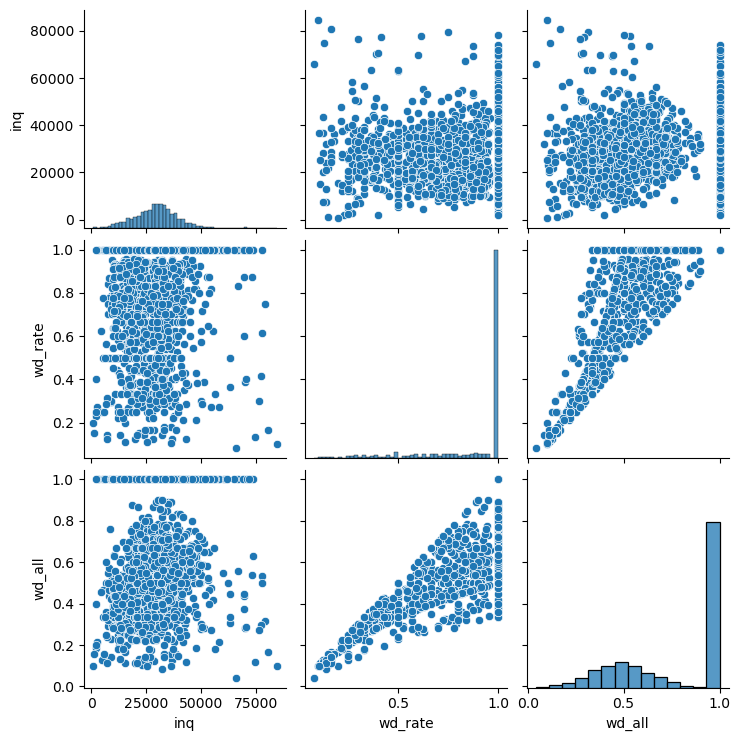

In [137]:
sns.pairplot(cluster_data[['inq', 'wd_rate', 'wd_all']])

In [129]:
cluster_data

id      lat      lon  cluster  cluster_size           inq wd_rate  \
1  6.0  54.9034  38.0696      0.0         989.0  15146.533333    0.75   
2  6.0  54.8933  38.0780      1.0         830.0  39723.665414     1.0   

     wd_all  
1  0.428571  
2  0.571429

In [85]:
# cluster_data['work_place'] = (cluster_data['inq'] < 28500) & (cluster_data['inq'] > 14000) | (cluster_data['inq'] > 40000) & (cluster_data['inq'] < 45000)

Первый способ: рабочий кластер, если на него пришлось меньше половины суммарного количества дней по всем кластерам пользователя, либо, если выше половины, размах меньше 25к секунд

In [226]:
cluster_data['work_place'] = (cluster_data['wd_all'] < 0.7) | ((cluster_data['wd_all'] >= 0.7) & (cluster_data['inq'] < 25000))

Второе правило

In [197]:
cluster_data['work_place'] = (cluster_data['wd_rate'] < 0.7) | ((cluster_data['wd_rate'] >= 0.7) & (cluster_data['inq'] < 30000))

In [214]:
cluster_data

id      lat      lon  cluster  cluster_size           inq wd_rate  \
0         2.0  54.8436  38.1929      0.0        5056.0     46681.775     1.0   
1         6.0  54.9034  38.0696      0.0         989.0  15146.533333    0.75   
2         6.0  54.8933  38.0780      1.0         830.0  39723.665414     1.0   
5        13.0  54.8428  38.1908      0.0        2908.0  38369.617647     1.0   
6        14.0  54.8419  38.1885      0.0        2213.0   35349.09434     1.0   
...       ...      ...      ...      ...           ...           ...     ...   
5355  36014.0  54.8840  38.0581      0.0        1399.0  31713.003268     1.0   
5356  36099.0  54.9429  38.0713      0.0        3069.0  28944.586667     1.0   
5358  36365.0  54.9423  38.1347      0.0        3963.0   33879.40293     1.0   
5363  36721.0  54.8860  38.0891      0.0        2429.0  36563.291667     1.0   
5365  37192.0  54.8448  38.1918      0.0        3194.0  33701.266667     1.0   

        wd_all  work_place  
0          1.0       False  
1     0.428571        True  
2     0.571429        True  
5          1.0       False  
6          1.0       False  
...        ...         ...  
5355       1.0       False  
5356       1.0        True  
5358       1.0       False  
5363       1.0       False  
5365       1.0       False  

[2835 rows x 9 columns]

<AxesSubplot:>

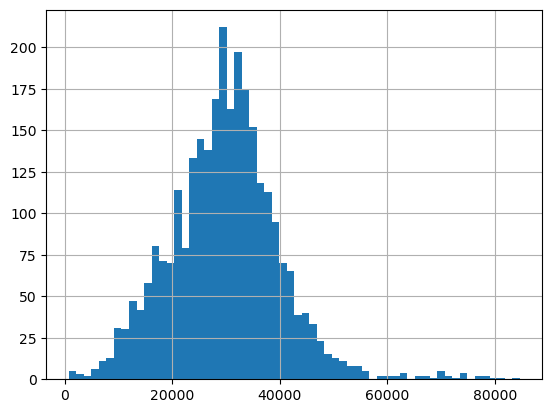

In [218]:
cluster_data['inq'].hist(bins=60)

In [227]:
cluster_data['work_place'].value_counts()

True     1503
False    1332
Name: work_place, dtype: int64

In [233]:
filtered_clusters = cluster_data[cluster_data['inq'].between(14000, 55000)]

In [234]:
filtered_clusters

id      lat      lon  cluster  cluster_size           inq wd_rate  \
0         2.0  54.8436  38.1929      0.0        5056.0     46681.775     1.0   
1         6.0  54.9034  38.0696      0.0         989.0  15146.533333    0.75   
2         6.0  54.8933  38.0780      1.0         830.0  39723.665414     1.0   
5        13.0  54.8428  38.1908      0.0        2908.0  38369.617647     1.0   
6        14.0  54.8419  38.1885      0.0        2213.0   35349.09434     1.0   
...       ...      ...      ...      ...           ...           ...     ...   
5355  36014.0  54.8840  38.0581      0.0        1399.0  31713.003268     1.0   
5356  36099.0  54.9429  38.0713      0.0        3069.0  28944.586667     1.0   
5358  36365.0  54.9423  38.1347      0.0        3963.0   33879.40293     1.0   
5363  36721.0  54.8860  38.0891      0.0        2429.0  36563.291667     1.0   
5365  37192.0  54.8448  38.1918      0.0        3194.0  33701.266667     1.0   

        wd_all  work_place  
0          1.0       False  
1     0.428571        True  
2     0.571429        True  
5          1.0       False  
6          1.0       False  
...        ...         ...  
5355       1.0       False  
5356       1.0       False  
5358       1.0       False  
5363       1.0       False  
5365       1.0       False  

[2624 rows x 9 columns]

In [235]:
filtered_clusters['work_place'].value_counts()

False    1319
True     1305
Name: work_place, dtype: int64

In [236]:
geometry = [Point(xy) for xy in zip(filtered_clusters['lon'], filtered_clusters['lat'])]
gdf = gpd.GeoDataFrame(filtered_clusters, geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='work_place', cmap=['blue', 'green', 'red', 'orange'])

In [237]:
filtered_clusters.to_csv('labeled_cluster_data.csv')

# Исследование на отдельных пользователях

In [7]:
cur_id = 519
cur_id_df = df.query('id == @cur_id and cluster != -1').copy()
data = cur_id_df[(pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek < 5)].copy()
cur_cluster_data = cluster_data[cluster_data['id'] == cur_id]
cur_cluster_data

id      lat      lon  cluster  cluster_size
202  519.0  54.8840  38.0825      0.0        2112.0
203  519.0  54.8872  38.0698      1.0        2151.0
204  519.0  54.8793  38.0747      2.0        1016.0

In [8]:
cur_id_df

lat      lon            ts     id  length  cluster    log_date   
846738  54.8840  38.0825  1.676430e+09  519.0    0.00        0  2023-02-15  \
846741  54.8874  38.0697  1.675826e+09  519.0  743.00        1  2023-02-08   
846742  54.8874  38.0697  1.675827e+09  519.0  743.00        1  2023-02-08   
846743  54.8875  38.0697  1.676346e+09  519.0   68.50        1  2023-02-14   
846744  54.8875  38.0697  1.676346e+09  519.0   68.50        1  2023-02-14   
...         ...      ...           ...    ...     ...      ...         ...   
852297  54.8875  38.0697  1.675214e+09  519.0  415.75        1  2023-02-01   
852298  54.8875  38.0697  1.675215e+09  519.0  415.75        1  2023-02-01   
852299  54.8875  38.0697  1.675215e+09  519.0  415.75        1  2023-02-01   
852300  54.8840  38.0825  1.676903e+09  519.0    0.00        0  2023-02-20   
852301  54.8840  38.0824  1.676612e+09  519.0    0.00        0  2023-02-17   

              day_ts  
846738  10775.000000  
846741  11572.000000  
846742  13058.000000  
846743  12868.000000  
846744  12939.761905  
...              ...  
852297   4670.333333  
852298   5224.666667  
852299   5779.000000  
852300  51670.000000  
852301  20173.000000  

[5279 rows x 8 columns]

In [55]:
data.groupby('cluster')['day_ts'].apply(lambda x: np.sum(x.between(A, B)) / x.shape[0])

cluster
0    0.955966
1    0.457635
2    0.724382
Name: day_ts, dtype: float64

In [56]:
for cluster in data['cluster'].unique():
    print(cluster, data.groupby(['cluster', 'log_date'])[['length']].sum().stack()[cluster].median())

0 18660.5
1 12862.0
2 28528.5


In [57]:
data.groupby(['cluster', 'log_date'])[['length']].sum().stack()

cluster  log_date          
0        2023-02-08  length    14630.0
         2023-02-14  length    18069.0
         2023-02-15  length    29892.0
         2023-02-16  length    26370.0
         2023-02-17  length    19252.0
         2023-02-20  length    11166.0
         2023-02-27  length     9858.0
         2023-02-28  length    22029.0
1        2023-01-31  length     7653.0
         2023-02-01  length    12862.0
         2023-02-03  length        0.0
         2023-02-08  length    13427.0
         2023-02-14  length    19784.0
         2023-02-15  length    30860.0
         2023-02-16  length    19051.0
         2023-02-17  length     2847.0
         2023-02-20  length     9455.0
         2023-02-27  length    30903.0
         2023-02-28  length    11569.0
2        2023-02-01  length    26372.0
         2023-02-02  length    30685.0
         2023-02-03  length    35774.0
         2023-02-20  length        0.0
dtype: float64

(0.0, 80000.0)

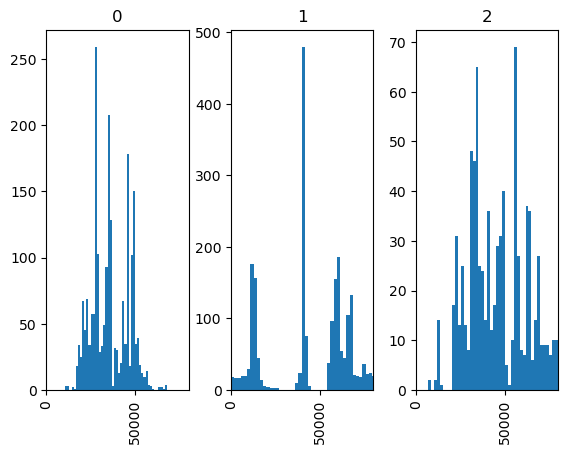

In [58]:
ax_list = data['day_ts'].hist(layout=(1,3), by=data['cluster'], bins=48)
ax_list[0].set_xlim((0, 80000))
ax_list[1].set_xlim((0, 80000))
ax_list[2].set_xlim((0, 80000))


In [59]:
cur_id_df.groupby('cluster')['log_date'].nunique()

cluster
0     8
1    12
2     5
Name: log_date, dtype: int64

In [60]:
cur_id_df['log_date'].nunique()

14

In [61]:
geometry = [Point(xy) for xy in zip(cur_cluster_data['lon'],cur_cluster_data['lat'])]
gdf = gpd.GeoDataFrame(cur_cluster_data , geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='work_place', cmap=['blue', 'green', 'red', 'orange'])

In [9]:
geometry = [Point(xy) for xy in zip(cur_id_df['lon'], cur_id_df['lat'])]
gdf = gpd.GeoDataFrame(cur_id_df, geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='cluster', cmap=['blue', 'green', 'red', 'orange'])